# Analysis of ProtonDB Linux Distribution
[[Return to home]](../index.md)

In [26]:
# !git clone https://github.com/bdefore/protondb-data

## Preprocessing

In [10]:
import os 
import pandas as pd
import glob
import tarfile
import json

In [11]:
def find_distro(string):
    os_str = string.split(" ")[0]
    
    distros = ["ubuntu","manjaro","arch","pop!_os","debian","fedora","linux mint"]
    
    if os_str.lower() not in distros and len(string.split(" "))>1:
        os_str += " " + string.split(" ")[1]

    manjaro_based = ["manjaro"]
    if any(x in os_str.lower() for x in manjaro_based):
        os_str = "Manjaro"
        
    arch_based = ["arc","antergos","gamer","ctlos","artix","endeavour"]
    if any(x in os_str.lower() for x in arch_based):
        os_str = "Arch"
        
    ubuntu_based = ["kde","elementary","zorin","ubuntu"]
    if any(x in os_str.lower() for x in ubuntu_based):
        os_str = "Ubuntu"
    
    mint_based = ["lmde","mint"]
    if any(x in os_str.lower() for x in mint_based):
        os_str = "Linux Mint"
        
    pop_based = ["pop"]
    if any(x in os_str.lower() for x in pop_based):
        os_str = "Pop!_OS"
    
#     suse_based = ["suse"]
#     if any(x in os_str.lower() for x in suse_based):
#         os_str = "OpenSUSE"
        
#     flatpack = ["freedesktop"]
#     if any(x in os_str.lower() for x in flatpack):
#         os_str = "Flatpak"
        
    debian_based = ["steamos","siduction","sparky","devuan","mx","deepin","debian"]
    if any(x in os_str.lower() for x in debian_based):
        os_str = "Debian"
        
    fedora_based = ["fedora"]
    if any(x in os_str.lower() for x in fedora_based):
        os_str = "Fedora"
        
    if os_str.lower() not in distros:
        os_str = "Others"
        
    return os_str

def read_os_from_tar(path):
    print("reading",path)
    with tarfile.open(path,"r") as f:
        data = f.extractfile("reports_piiremoved.json").read()
    data = json.loads(data)
    data = pd.DataFrame(data)
    
    date_str = os.path.split(path)[1][8:-7]
    month = date_str[:3]
    day = date_str[3]
    year = date_str[5:]
    date_str = pd.to_datetime("-".join([month,day,year]))
    
    if date_str >= pd.to_datetime("dec-2-2019"):
        df = pd.json_normalize(data['systemInfo'])
    else:
        df = data.dropna(subset=["os"]).copy()
        
    df["os"]=df["os"].apply(find_distro)
    os_data = df["os"].value_counts()
    os_df = pd.DataFrame(os_data).transpose().reset_index(drop=True)
    os_df["date"] = date_str
    
    return os_df

In [16]:
if False:#os.path.exists("proton_db_os.hdf5"):
    df_report = pd.read_hdf("proton_db_os.hdf5","df")
else:
    df_report = pd.DataFrame(read_os_from_tar('protondb-data/reports/reports_dec2_2019.tar.gz'))
    
for path in glob.glob("protondb-data/reports/*.gz"):
    date_str = os.path.split(path)[1][8:-7]
    month = date_str[:3]
    day = date_str[3]
    year = date_str[5:]
    date_str = pd.to_datetime("-".join([month,day,year]))
    if date_str not in df_report["date"].to_numpy():
        try:
            df_temp = read_os_from_tar(path)
        except:
            continue
        df_report = pd.concat([df_report,df_temp],ignore_index=True)

reading protondb-data/reports/reports_dec2_2019.tar.gz
reading protondb-data/reports/reports_apr1_2019.tar.gz
reading protondb-data/reports/reports_apr1_2020.tar.gz
reading protondb-data/reports/reports_apr1_2021.tar.gz
reading protondb-data/reports/reports_apr1_2022.tar.gz
reading protondb-data/reports/reports_aug1_2019.tar.gz
reading protondb-data/reports/reports_aug1_2021.tar.gz
reading protondb-data/reports/reports_dec1_2018.tar.gz
reading protondb-data/reports/reports_dec1_2020.tar.gz
reading protondb-data/reports/reports_dec1_2021.tar.gz
reading protondb-data/reports/reports_feb1_2019.tar.gz
reading protondb-data/reports/reports_feb1_2020.tar.gz
reading protondb-data/reports/reports_feb1_2021.tar.gz
reading protondb-data/reports/reports_feb1_2022.tar.gz
reading protondb-data/reports/reports_jan1_2019.tar.gz
reading protondb-data/reports/reports_jan1_2020.tar.gz
reading protondb-data/reports/reports_jan1_2021.tar.gz
reading protondb-data/reports/reports_jan1_2022.tar.gz
reading pr

In [17]:
df_report.to_hdf("proton_db_os.hdf5","df")

## Cumulative Results

**Note:** On Dec 2nd 2019, ProtonDB contribute workflow changed to a questionnaire, subsequently changed the data structures. All data prior to this date are for reference only and should NOT be inferred.

### Raw user counts per distro

<AxesSubplot:xlabel='date'>

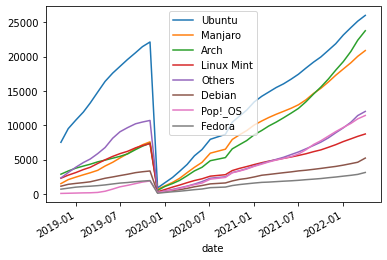

In [20]:
df_report.plot(x="date")

### Normalized distro market share on ProtonDB

<AxesSubplot:xlabel='date'>

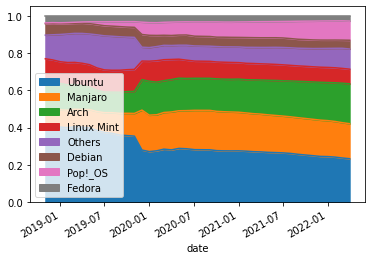

In [21]:
normalizedDataFrame = df_report[df_report.columns[:-1]].div(df_report[df_report.columns[:-1]].sum(axis=1), axis=0)
normalizedDataFrame["date"]=df_report["date"]
normalizedDataFrame.plot.area(x="date",stacked=True)

### Normalized distro market share on ProtonDB (Merged distro base)

In [27]:
normalizedDataFrame_combined = normalizedDataFrame.copy()
normalizedDataFrame_combined["Arch"]=normalizedDataFrame_combined[["Arch","Manjaro"]].sum(axis=1)
normalizedDataFrame_combined = normalizedDataFrame_combined.drop(columns="Manjaro")
normalizedDataFrame_combined["Debian"]=normalizedDataFrame_combined[["Linux Mint","Ubuntu","Pop!_OS","Debian"]].sum(axis=1)
normalizedDataFrame_combined = normalizedDataFrame_combined.drop(columns=["Linux Mint","Pop!_OS","Ubuntu"])

<AxesSubplot:xlabel='date'>

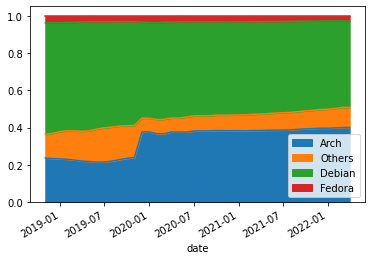

In [28]:
normalizedDataFrame_combined.plot.area(x="date",stacked=True)

Arch Linux and Arch-based distro is on the rise, while Debian-based (Ubuntu) distros are on the decline. Is this a shift due to Steam Deck and SteamOS? We'll filter from Jan 1st 2022 till now to see if there is a shift in the market share.

<AxesSubplot:xlabel='date'>

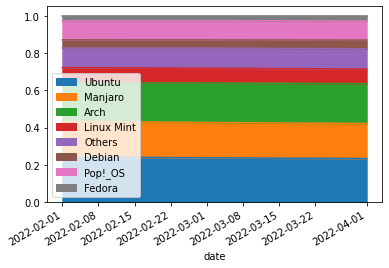

In [33]:
normalizedDataFrame[normalizedDataFrame["date"]>pd.to_datetime("jan-1-2022")].plot.area(x="date",stacked=True)

<AxesSubplot:xlabel='date'>

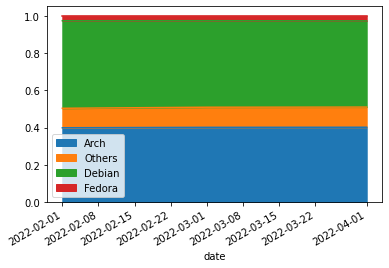

In [32]:
normalizedDataFrame_combined[normalizedDataFrame_combined["date"]>pd.to_datetime("jan-1-2022")].plot.area(x="date",stacked=True)

The data is ambiguous, we'll need to see monthly increased user counts to see if this is the case.

## Monthly delta of user counts

<AxesSubplot:xlabel='date'>

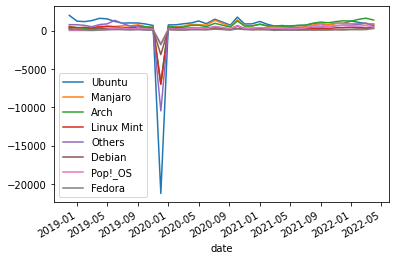

In [53]:
df_delta = df_report.sort_values(by="date",ascending=False)-df_report.sort_values(by="date",ascending=False).shift(-1)
df_delta.pop("date")
df_delta["date"]=df_report["date"]
df_delta.plot(x="date")

Let's zoom in after Dec 2nd 2019 (when the questionnaire was released)

<AxesSubplot:xlabel='date'>

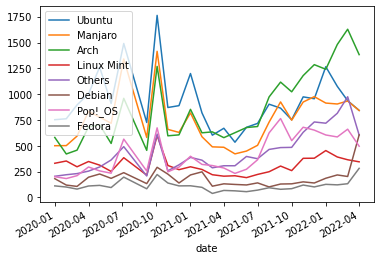

In [54]:
df_delta = df_delta[df_delta["date"]>pd.to_datetime("dec-2-2019")]
df_delta.plot(x="date")

In [56]:
normalizedDataFrame = df_delta[df_delta.columns[:-1]].div(df_delta[df_delta.columns[:-1]].sum(axis=1), axis=0)
normalizedDataFrame["date"]=df_delta["date"]
normalizedDataFrame_combined = normalizedDataFrame.copy()
normalizedDataFrame_combined["Arch"]=normalizedDataFrame_combined[["Arch","Manjaro"]].sum(axis=1)
normalizedDataFrame_combined = normalizedDataFrame_combined.drop(columns="Manjaro")
normalizedDataFrame_combined["Debian"]=normalizedDataFrame_combined[["Linux Mint","Ubuntu","Pop!_OS","Debian"]].sum(axis=1)
normalizedDataFrame_combined = normalizedDataFrame_combined.drop(columns=["Linux Mint","Pop!_OS","Ubuntu"])

<AxesSubplot:xlabel='date'>

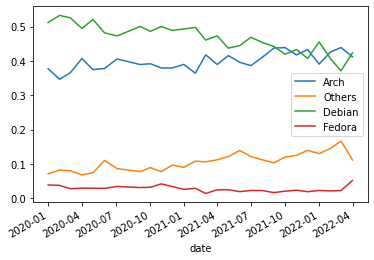

In [64]:
normalizedDataFrame_combined.plot(x="date")

Debian-based new installation is on a constant decline, while arch and "other" distros are on a rise. As the market share of "other" distros is not as significant as Debian or Arch derivatives, we won't go deeper into this category.

<AxesSubplot:xlabel='date'>

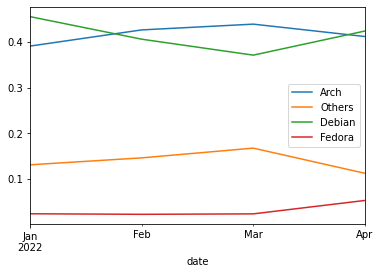

In [63]:
normalizedDataFrame_combined[normalizedDataFrame_combined["date"]>pd.to_datetime("dec-1-2021")].plot(x="date")

New install of both Arch and Debian-based distros is on plateau. So for now, the release of Steam Deck is not that big of a disruption. Interestingly, in April there is a spike in installation of Fedora